In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

ModuleNotFoundError: No module named 'seal'

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'banknote_authentication.txt'), names=['variance', 'skewness', 'curtosis',
                                                                                    'entropy', 'class'])

In [3]:
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1098, 4) (136, 4) (138, 4)
(1098,) (136,) (138,)


In [4]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

In [5]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title('Final layer values')
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('encrypted')
    ax.set_ylabel('unencrypted')
    ax.plot(np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [7]:
def relu(z):
    return np.maximum(0, z)

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Unencrypted

In [6]:
weights = np.load('relu_weights.npy')
w1, b1, w2, b2 = weights

In [9]:
layer1_clear = X_test.dot(w1) + b1
layer1_relu_clear = relu(layer1_clear)
layer2_clear = layer1_relu_clear.dot(w2) + b2
pred_clear = sigmoid(layer2_clear)

In [13]:
pred_clear = np.round(pred_clear.reshape(-1,))

In [16]:
accuracy_score(pred_clear, y_test)

0.9782608695652174

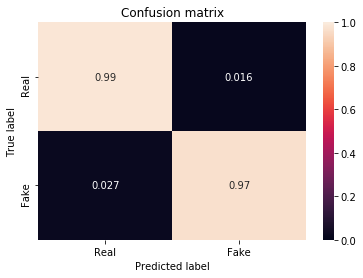

In [17]:
mat = confusion_matrix(pred_clear, y_test)
cm = mat / np.sum(mat, axis=1)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

## Encrypted

In [18]:
X_test_enc = EA(X_test, to_encrypt=True)
w1_enc = EA(w1)
b1_enc = EA(b1.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [19]:
layer1_enc = X_test_enc.dot(w1_enc) + b1_enc
layer1_relu_enc = layer1_enc.relu()
layer2_enc = layer1_relu_enc.dot(w2_enc) + b2_enc

In [20]:
pred_enc = sigmoid(layer2_enc.values())

In [22]:
pred_enc = np.round(pred_enc.reshape(-1,))

In [23]:
accuracy_score(pred_enc, y_test)

0.9782608695652174

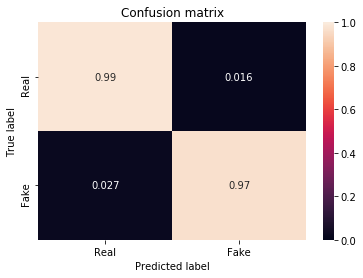

In [25]:
mat = confusion_matrix(pred_enc, y_test)
cm = mat / np.sum(mat, axis=1)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

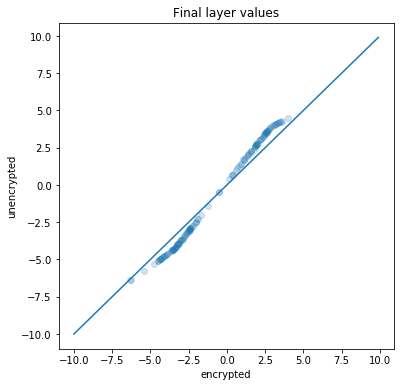

In [38]:
# final layer
plot_predictions(layer2_enc.values(), layer2_clear)